In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Define the Pose Estimation Model
class PoseEstimationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoseEstimationNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class ObjectDatasetByID(Dataset):
    def __init__(self, data_2d_path, data_3d_path):
        self.data_by_id = defaultdict(lambda: {"2d": [], "3d": []})
        self.expected_output_size = 31  # Expected output size based on structure

        files_2d = sorted([f for f in os.listdir(data_2d_path) if f.endswith('.csv')])
        
        for file_2d in files_2d:
            data_2d_file_path = os.path.join(data_2d_path, file_2d)
            data_3d_file_path = os.path.join(data_3d_path, file_2d)

            if not os.path.exists(data_3d_file_path):
                print(f"Skipping; 3D file missing for: {file_2d}")
                continue

            try:
                df_2d = pd.read_csv(data_2d_file_path, header=None)
                df_3d = pd.read_csv(data_3d_file_path, header=None)

                if len(df_2d) != len(df_3d):
                    print(f"Skipping; row count mismatch in files: {file_2d}")
                    continue
                if df_3d.shape[1] != self.expected_output_size:
                    print(f"Skipping; 3D data size mismatch for file {file_2d}")
                    continue

                for row_2d, row_3d in zip(df_2d.values, df_3d.values):
                    obj_id = int(row_2d[0])  # First column is the ID
                    self.data_by_id[obj_id]["2d"].append(torch.tensor(row_2d[1:], dtype=torch.float32)) 
                    self.data_by_id[obj_id]["3d"].append(torch.tensor(row_3d[1:], dtype=torch.float32))

            except (pd.errors.EmptyDataError, ValueError):
                print(f"Skipping invalid file pair: {file_2d}")

    def get_data_by_id(self):
        # Returns the data separated by ID
        return {obj_id: (torch.stack(data["2d"]), torch.stack(data["3d"]))
                for obj_id, data in self.data_by_id.items()}


In [21]:
import torch.optim as optim
import time

# Evaluation function
def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(data_loader)

# Training function with early stopping
def train_model_for_id(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, device='cpu', obj_id=None):
    model.to(device)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    print(f"\n{'='*50}")
    print(f"Training Start for ID {obj_id}")
    print(f"{'='*50}\n")

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        train_loss = running_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion, device)
        epoch_time = time.time() - start_time

        print(f"ID: {obj_id} - Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s, "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            model_save_path = f"sye_models/sye{obj_id}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Validation loss improved. Model for ID {obj_id} saved to {model_save_path}\n")
        else:
            epochs_without_improvement += 1
            print(f"No improvement in validation loss for {epochs_without_improvement} epochs.\n")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered for ID {obj_id} after {epoch+1} epochs.")
            break


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

base_path = "C:\\Users\\sakar\\OneDrive\\mt-datas\\synthetic_data"
dataset_name = "4_2_texture_door_window_household"
data_2d_subfolder = "2d_data"
data_3d_subfolder = "3d_data"

# Construct paths to the data directories
data_2d_path = os.path.join(base_path, dataset_name, data_2d_subfolder)
data_3d_path = os.path.join(base_path, dataset_name, data_3d_subfolder)

# Load the dataset and get data by ID
object_dataset_by_id = ObjectDatasetByID(data_2d_path, data_3d_path)
data_by_id = object_dataset_by_id.get_data_by_id()

# Model parameters
input_size = 20
output_size = 30
learning_rate = 0.001
num_epochs = 50
patience = 5  # Early stopping patience

# Loss function
criterion = nn.MSELoss()

# Loop through each unique ID to train and save models
for obj_id, (data_2d, data_3d) in data_by_id.items():
    # Split data for the current ID
    dataset = torch.utils.data.TensorDataset(data_2d, data_3d)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Create and train model
    model = PoseEstimationNet(input_size=input_size, output_size=output_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"\nStarting training for ID {obj_id}")
    train_model_for_id(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience, device='cpu', obj_id=obj_id)


Skipping invalid file pair: 1003.csv
Skipping invalid file pair: 1033.csv
Skipping invalid file pair: 1035.csv
Skipping invalid file pair: 105.csv
Skipping invalid file pair: 1056.csv
Skipping invalid file pair: 1057.csv
Skipping invalid file pair: 1062.csv
Skipping invalid file pair: 1070.csv
Skipping invalid file pair: 1108.csv
Skipping invalid file pair: 1124.csv
Skipping invalid file pair: 1136.csv
Skipping invalid file pair: 1141.csv
Skipping invalid file pair: 1145.csv
Skipping invalid file pair: 1181.csv
Skipping invalid file pair: 1196.csv
Skipping invalid file pair: 1199.csv
Skipping invalid file pair: 1210.csv
Skipping invalid file pair: 1222.csv
Skipping invalid file pair: 1224.csv
Skipping invalid file pair: 1228.csv
Skipping invalid file pair: 1233.csv
Skipping invalid file pair: 1258.csv
Skipping invalid file pair: 1341.csv
Skipping invalid file pair: 1343.csv
Skipping invalid file pair: 1375.csv
Skipping invalid file pair: 1384.csv
Skipping invalid file pair: 1390.csv
Sk

In [7]:
import torch
import pandas as pd
import os

base_path = r"C:\Users\sakar\OneDrive\mt-datas\yolo\pose_estimation"
filename = "result.csv"

# Construct paths to the data directories
data_2d_sample_path = os.path.join(base_path, filename)

# Define the function to load the trained model and use it for inference
def load_model_and_predict_3d(data_2d_path, model_path="sye_models/sye0.pth", input_size=20, output_size=30):
    # Instantiate the model architecture and load weights
    model = PoseEstimationNet(input_size=input_size, output_size=output_size)
    model.load_state_dict(torch.load(model_path, weights_only=True))  # Added `weights_only=True`
    model.eval()  # Set the model to evaluation mode

    # Load the 2D data for inference
    try:
        df_2d = pd.read_csv(data_2d_path, header=None)
        df_2d = df_2d.iloc[:, 1:]  # Drop the ID column
        data_2d_tensor = torch.tensor(df_2d.values, dtype=torch.float32)
    except Exception as e:
        print(f"Error loading or processing 2D data: {e}")
        return None

    # Run the model to predict 3D points
    with torch.no_grad():
        predictions_3d = model(data_2d_tensor)
    
    print(predictions_3d)
    return predictions_3d

predictions_3d = load_model_and_predict_3d(data_2d_sample_path)

tensor([[-3.7424e+00, -1.1552e+00,  2.6423e+00,  3.9357e-03,  7.6561e+01,
          3.5437e-03, -3.5117e+00, -1.5038e-01,  2.8142e+00, -3.4683e+00,
         -1.5064e-01,  2.2956e+00, -3.9790e+00, -1.5058e-01,  2.3431e+00,
         -3.9660e+00, -1.4405e-01,  2.8504e+00, -3.4934e+00, -1.1614e+00,
          2.8443e+00, -3.4872e+00, -1.1640e+00,  2.3166e+00, -4.0132e+00,
         -1.1514e+00,  2.3143e+00, -3.9723e+00, -1.1639e+00,  2.8365e+00]])


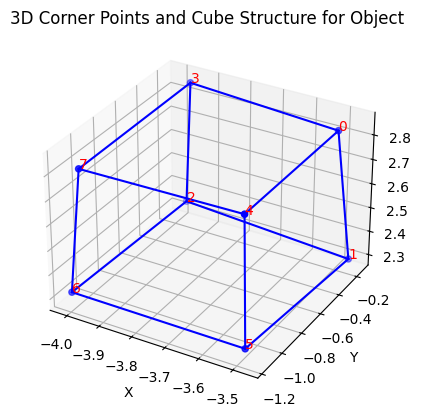

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot 3D corner points from predictions and connect them to form a cube
def plot_3d_corners(predictions_3d):
    # Check if predictions are available
    if predictions_3d is None:
        print("No predictions to plot.")
        return
    
    # Extract the last 24 elements for the 8 corner points (each corner has 3 coordinates)
    corner_predictions = predictions_3d[:, -24:].view(-1, 8, 3)

    # Plot each object’s corners in a 3D space
    for i, corners in enumerate(corner_predictions):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Coordinates of the corners
        x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        # Annotate each corner for clarity
        for j, (x_coord, y_coord, z_coord) in enumerate(corners):
            ax.text(x_coord, y_coord, z_coord, f"{j}", color="red")

        # Define connections for the cube
        connections = [
            (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom square
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top square
            (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges connecting squares
        ]

        # Plot lines for each connection
        for start, end in connections:
            ax.plot(
                [x[start], x[end]],
                [y[start], y[end]],
                [z[start], z[end]],
                'b-'
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.title(f"3D Corner Points and Cube Structure for Object")
        plt.show()

# Plot the 3D corners from the predictions
plot_3d_corners(predictions_3d)


# To Validate Results with Actual Data

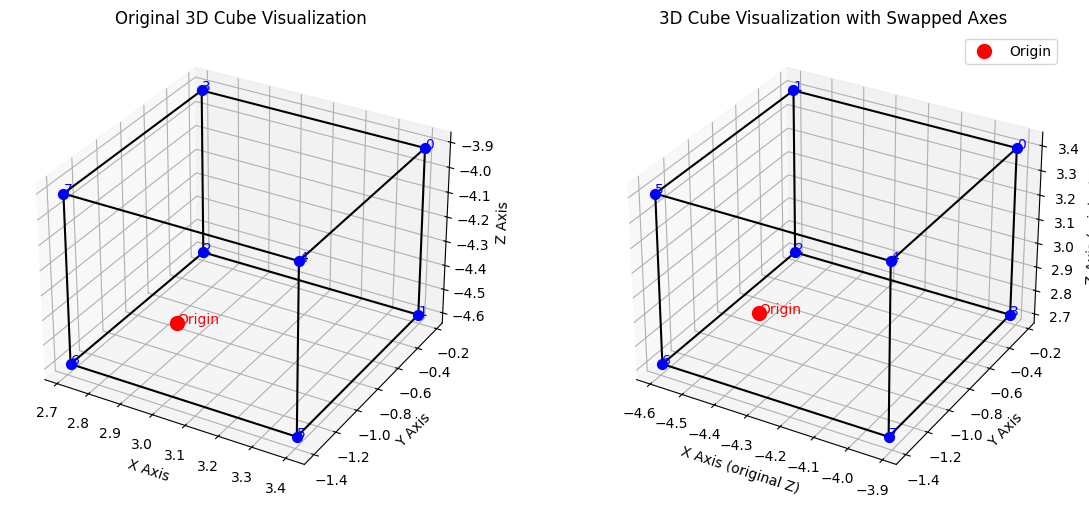

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the points as a list of tuples (x, y, z)
points = [
    (3.049782, -1.4, -4.28893),  # Origin
    (3.404064, -0.2259196, -3.91012),
    (3.404064, -0.2259196, -4.593021),
    (2.711343, -0.2259196, -4.593021),
    (2.711343, -0.2259196, -3.91012),
    (3.404064, -1.4, -3.91012),
    (3.404064, -1.4, -4.593021),
    (2.711343, -1.4, -4.593021),
    (2.711343, -1.4, -3.91012)
]

# Define the edges of the cube by connecting the vertices
edges = [
    (1, 2), (2, 3), (3, 4), (4, 1),  # Top square
    (5, 6), (6, 7), (7, 8), (8, 5),  # Bottom square
    (1, 5), (2, 6), (3, 7), (4, 8)   # Vertical connections
]

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(14, 6))

# Original 3D cube visualization
ax1 = fig.add_subplot(121, projection='3d')
for i, (x, y, z) in enumerate(points):
    if i == 0:
        ax1.scatter(x, y, z, color='red', s=100, label="Origin")  # Larger, red point for origin
        ax1.text(x, y, z, "Origin", color='red')
    else:
        ax1.scatter(x, y, z, color='blue', s=50)  # Blue points for other points
        ax1.text(x, y, z, f"{i-1}", color='blue')  # Label from 0 to 7

# Draw the edges for the original cube
for start, end in edges:
    x_line = [points[start][0], points[end][0]]
    y_line = [points[start][1], points[end][1]]
    z_line = [points[start][2], points[end][2]]
    ax1.plot(x_line, y_line, z_line, color="black")

# Setting labels and title for the original plot
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.set_title("Original 3D Cube Visualization")

# Swapped axes visualization
ax2 = fig.add_subplot(122, projection='3d')
points_swapped = [(z, y, x) for x, y, z in points]  # Swap x and z values
for i, (x, y, z) in enumerate(points_swapped):
    if i == 0:
        ax2.scatter(x, y, z, color='red', s=100, label="Origin")  # Larger, red point for origin
        ax2.text(x, y, z, "Origin", color='red')
    else:
        ax2.scatter(x, y, z, color='blue', s=50)  # Blue points for other points
        ax2.text(x, y, z, f"{i-1}", color='blue')  # Label from 0 to 7

# Draw the edges for the swapped cube
for start, end in edges:
    x_line = [points_swapped[start][0], points_swapped[end][0]]
    y_line = [points_swapped[start][1], points_swapped[end][1]]
    z_line = [points_swapped[start][2], points_swapped[end][2]]
    ax2.plot(x_line, y_line, z_line, color="black")

# Setting labels and title for the swapped axes plot
ax2.set_xlabel("X Axis (original Z)")
ax2.set_ylabel("Y Axis")
ax2.set_zlabel("Z Axis (original X)")
ax2.set_title("3D Cube Visualization with Swapped Axes")

# Show the combined plot with a legend
plt.legend()
plt.show()
